### Operator Learning for an Inverse Problem with noise

In this notebook we now switch role of input and output to learn the inverse mapping of the PDE:
\begin{align*}
    \partial_t u(t) &= 5.0f(t) \quad \text{ for } t \in (0, 1), \\
    u(0) &= 0.
\end{align*}
Hence, the goal is to train one network that outputs $f$ for a given $u$ with some noise. 

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [ ]:
save_path = "/localdata/komso/datasets/Data_integrator"
# Now we switch the roles of u and f:
output_f = torch.load(f"{save_path}/input_f.pt")
input_u = torch.load(f"{save_path}/output_u.pt")

input_u += 0.1*torch.randn_like(input_u) # Here, we add some noise

print("Time discretization:", input_u.shape[1])
print("Available data points:", len(input_u))
print("Shape of data:", input_u.shape)

in_discretization = input_u.shape[1]
out_discretization = input_u.shape[1]

Time discretization: 100
Available data points: 20000
Shape of data: torch.Size([20000, 100, 1])


Next, we can have a look at one example of our data set.

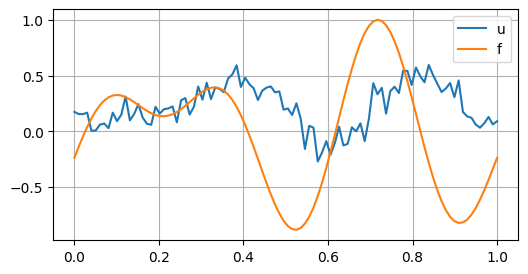

In [3]:
example_idx = 19
plt.figure(0, figsize=(6, 3))
time_grid = torch.linspace(0, 1, in_discretization)
plt.plot(time_grid, input_u[example_idx])
plt.plot(time_grid, output_f[example_idx])
plt.grid()
leg = plt.legend(["u", "f"])

Next we implement the *Spaces* that appear in the problem. Now we have additional *FunctionSpaces* defining what kind of functions appear in the problem.

In [4]:
# TODO: Still define the same spaces as before
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

fn_space_F = tp.spaces.FunctionSpace(T, F)
fn_space_U = tp.spaces.FunctionSpace(T, U)

We split our data into training and testing set. Such that we only train on one part of the data and afterwards can validate our model on the unseen testing set.

In [5]:
# Split data into training and testing:
total_data = len(input_u)
train_N = int(0.8*total_data) # we use 80% of the data for training

train_f = output_f[:train_N]
train_u = input_u[:train_N]

test_f = output_f[train_N:]
test_u = input_u[train_N:]

# TODO: Create the functionsets, combining the discrete data with the correct
# function space (Remember that u is now the input and f the output!)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_U, train_u)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_F, train_f)

The samplers are the same as before:

In [6]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(6000, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

Now we define our neural network that should learn the operator. As explained we use a FCN mapping $u$ (on the time grid) to $f$ (on the same grid).

In [7]:
# TODO: Set the correct input and output space
model = tp.models.Operator_FCN(input_fn_space=fn_space_U, 
                               output_fn_space=fn_space_F, 
                               in_discretization=in_discretization, 
                               out_discretization=out_discretization,
                               hidden=(50, 50))

The training condition also stays the same (since we already changed the roles of $u$ and $f$ in the previous cells).

In [8]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

Start the training:

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.005,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 3000, "gamma":0.25})

# As before define the solver and trainer:
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=10000, 
                    logger=False, 
                    callbacks=[RichProgressBar(theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 12.7 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 10000/10000 [00:45<00:00, 219.17it/s, train/loss=0.0158]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [00:45<00:00, 219.16it/s, train/loss=0.0158]


Finally, we check the performance on the test data.

In [13]:
model_output = model(tp.spaces.Points(test_u, U)).as_tensor.detach()
rel_error = torch.max(torch.abs(model_output - test_f)) / torch.max(torch.abs(test_u))
print(f"Relative error on test data: {rel_error*100} %")

Relative error on test data: 14.486154556274414 %


We can also visualize the performance:

Example plot:


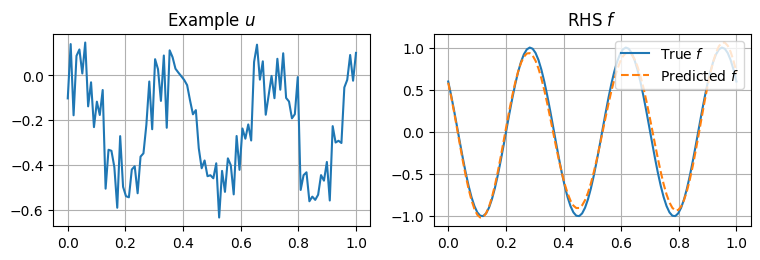

In [21]:
print("Example plot:")
plot_idx = 19
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(time_grid, test_u[plot_idx])
axarr[0].title.set_text(r"Example $u$")
axarr[0].grid()
axarr[1].plot(time_grid, test_f[plot_idx])
axarr[1].plot(time_grid, model_output[plot_idx], linestyle="--")
axarr[1].title.set_text(r"RHS $f$")
axarr[1].grid()
leg = axarr[1].legend([r"True $f$", r"Predicted $f$"], loc="upper right")